# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах:  
/datasets/geo_data_0.csv  
/datasets/geo_data_1.csv   
/datasets/geo_data_2.csv  

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек;  
`product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Загрузка данных и пропуски

In [93]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [94]:
try:
    df0 = pd.read_csv('C:\\Users\\gorbu\\OneDrive\\Документы\\DataScience\\Projects\\7 prj\\geo_data_0.csv')
except:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [95]:
try:
    df1 = pd.read_csv('C:\\Users\\gorbu\\OneDrive\\Документы\\DataScience\\Projects\\7 prj\\geo_data_1.csv')
except:
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [96]:
try:
    df2 = pd.read_csv('C:\\Users\\gorbu\\OneDrive\\Документы\\DataScience\\Projects\\7 prj\\geo_data_2.csv')
except:
    df2 = pd.read_csv('/datasets/geo_data_2.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все ровно, аккуратно. Пропусков нет.

### Обзор и дубликаты

In [97]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [98]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [99]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Непонятное, но красивое! Стандартизируем данные (после разделения выборок).

In [100]:
#код ревьюера
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [101]:
df0.duplicated().sum()

0

In [102]:
df1.duplicated().sum()

0

In [103]:
df2.duplicated().sum()

0

Явных дубликатов нет.

### Удаление лишних столбцов

Для обучения не понадобятся столбцы id скважин. Удалим.

In [104]:
df0 = df0.drop('id', axis = 1)
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [105]:
df1 = df1.drop('id', axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [106]:
df2 = df2.drop('id', axis = 1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


### Статистики запасов скважин регионов

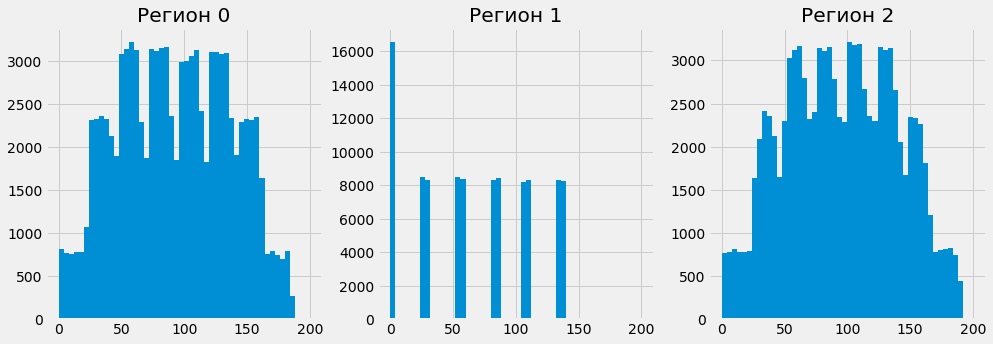

In [107]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].hist(df0["product"], range= (0,200), bins=50, rwidth=1)
axs[0].set_title('Регион 0')

axs[1].hist(df1["product"], range= (0,200), bins=50, rwidth=1)
axs[1].set_title('Регион 1')

axs[2].hist(df2["product"], range= (0,200), bins=50, rwidth=1)
axs[2].set_title('Регион 2')

plt.show()

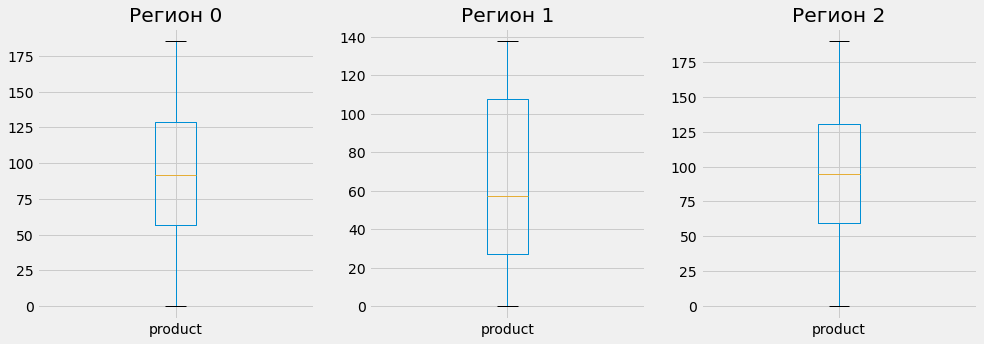

In [108]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df0.boxplot(column='product', ax=axs[0])
axs[0].set_title('Регион 0')

df1.boxplot(column='product', ax=axs[1])
axs[1].set_title('Регион 1')

df2.boxplot(column='product', ax=axs[2])
axs[2].set_title('Регион 2')

plt.show()

In [109]:
stats = pd.DataFrame({
    'stat':['min', 'mean', 'median', 'max'],
    "region_0":[df0['product'].min(), df0['product'].mean(), df0['product'].median(), df0['product'].max()], 
    "region_1":[df1['product'].min(), df1['product'].mean(), df1['product'].median(), df1['product'].max()],
    "region_2":[df2['product'].min(), df2['product'].mean(), df2['product'].median(), df2['product'].max()]})
stats

,stat,region_0,region_1,region_2
0,min,0.000000,0.000000,0.000000
1,mean,92.500000,68.825000,95.000000
2,median,91.849972,57.085625,94.925613
3,max,185.364347,137.945408,190.029838


Распределения запасов внутри регионов 0 и 2 напоминают нормальные, с пилообразными выбросами, регион 1 совершенно непохож. по статистикам также регмионы 0 и 2 схожи между собой, регион 1 менее богат запасами.

### Разделение выборок

Напишем функцию для разделения выборок.

In [110]:
def sample_split(df):
    target = df['product']
    features = df.drop(['product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [111]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = sample_split(df0)

print(features_train_0.shape)
print(features_valid_0.shape)

print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [112]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = sample_split(df1)

print(features_train_1.shape)
print(features_valid_1.shape)

print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [113]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = sample_split(df2)

print(features_train_2.shape)
print(features_valid_2.shape)

print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


### Стандартизация признаков и подготовка целевых признаков

In [114]:
scaler = StandardScaler()
scaler.fit(features_train_0)
features_train = scaler.transform(features_train_0)
features_valid = scaler.transform(features_valid_0)

In [115]:
scaler.fit(features_train_1)
features_train = scaler.transform(features_train_1)
features_valid = scaler.transform(features_valid_1)

In [116]:
scaler.fit(features_train_2)
features_train = scaler.transform(features_train_2)
features_valid = scaler.transform(features_valid_2)

In [117]:
target_valid_0

71751     10.038645
80493    114.551489
2655     132.603635
53233    169.072125
91141    122.325180
            ...    
12581    170.116726
18456     93.632175
73035    127.352259
63834     99.782700
43558    177.821022
Name: product, Length: 25000, dtype: float64

Сбросим индексы.

In [118]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_0

0         10.038645
1        114.551489
2        132.603635
3        169.072125
4        122.325180
            ...    
24995    170.116726
24996     93.632175
24997    127.352259
24998     99.782700
24999    177.821022
Name: product, Length: 25000, dtype: float64

In [119]:
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

## Обучение и проверка модели

In [120]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predicted_valid_0 = model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predicted_valid_0, squared=False)
print('Средний запас предсказанного сырья:', predicted_valid_0.mean())
print('RMSE модели:', rmse_0)
print("R2 модели:", r2_score(target_valid_0, predicted_valid_0))

Средний запас предсказанного сырья: 92.59256778438035
RMSE модели: 37.5794217150813
R2 модели: 0.27994321524487786


In [121]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1, squared=False)
print('Средний запас предсказанного сырья:', predicted_valid_1.mean())
print('RMSE модели:', rmse_1)
print("R2 модели:", r2_score(target_valid_1, predicted_valid_1))

Средний запас предсказанного сырья: 68.72854689544602
RMSE модели: 0.8930992867756165
R2 модели: 0.9996233978805127


In [122]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2, squared=False)
print('Средний запас предсказанного сырья:', predicted_valid_2.mean())
print('RMSE модели:', rmse_2)
print("R2 модели:", r2_score(target_valid_2, predicted_valid_2))

Средний запас предсказанного сырья: 94.96504596800489
RMSE модели: 40.02970873393434
R2 модели: 0.20524758386040443


Регион 1 так и остается выделяющимся, но какова модель! R2 почти единица, корень из среднеквадратичной ошибки - ничтожен!
Средние предсказанные запасы 68,7, реальные средние - 68,8!

В регионах 0 и 2 корень из среднеквадратичной ошибки - 40,6% и 42,1% от среднего запаса предсказанного сырья соответственно.

## Подготовка к расчету прибыли

Рассчитаем точку безубыточности. Если 10 млрд. рублей тратится на разработку скважин в регионе, а тысяча баррелей дает 450 тыс. рублей выручки, то точку безубыточности найдем разделив 10 млрд. рублей на 450 тыс. рублей за тысячу баррелей. Поскольку разроабатывается 200 скважин с самыми большими запасами сырья в каждом регионе, то разделим еще на 200 - получим средний запас одной скважины для безубыточной добычи с двухсот скважин в одном регионе.

In [123]:
costs = 10000000000
revenue = 450000
mines = 200
break_even = costs / (revenue * mines)
break_even

111.11111111111111

Средние запасы каждой из 200 лучших скважин в регионе должны быть 111.(1) тысяч баррелей для безубыточной добычи в регионе. Это значение выше, чем средние значения скважин во всех трех регионах.

Подготовим функцию для расчета прибыли.

In [124]:
def profit(target, probabilities, count):
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit = revenue * selected.sum() - costs
    return profit 

## Расчёт прибыли и рисков 

Напишем функцию для сэмплирования и расчета доверительного интервала.

In [125]:
def bootstrap_sample(target_valid, predicted_valid):
    state = np.random.RandomState(12345)
    
    values = []
    count = 0
    for i in range(1000):
        target_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        probs_subsample = pd.Series(predicted_valid).iloc[target_subsample.index]
        sample_profit = profit(target_subsample, probs_subsample, mines)
        values.append(sample_profit)
        if sample_profit < 0:
            count += 1

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)


    print("95%-ый доверительный интервал: от 2.5%-квантили:", lower, "до 97.5%-квантили:", upper)
    print("Средняя прибыль:", values.mean())
    print("Доля выборок (200 скважин на регион) с убытками, %:", count / 10)

    values.hist(bins=50, rwidth=1)


### Регион 0 

95%-ый доверительный интервал: от 2.5%-квантили: -102090094.83793654 до 97.5%-квантили: 947976353.3583689
Средняя прибыль: 425938526.91059244
Доля выборок (200 скважин на регион) с убытками, %: 6.0


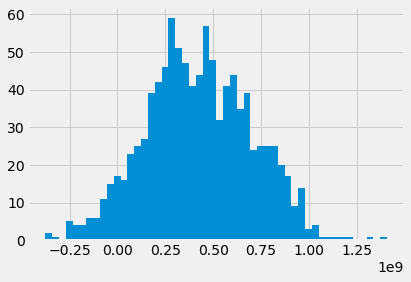

In [126]:
bootstrap_sample(target_valid_0, predicted_valid_0)

### Регион 1 

95%-ый доверительный интервал: от 2.5%-квантили: 68873225.37050176 до 97.5%-квантили: 931547591.2570494
Средняя прибыль: 515222773.4432899
Доля выборок (200 скважин на регион) с убытками, %: 1.0


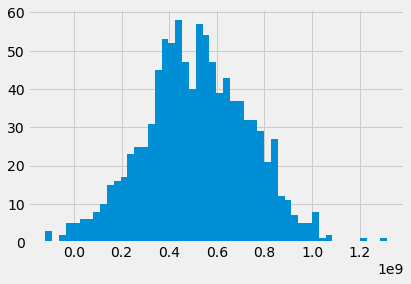

In [127]:
bootstrap_sample(target_valid_1, predicted_valid_1)

### Регион 2 

95%-ый доверительный интервал: от 2.5%-квантили: -128880547.32978901 до 97.5%-квантили: 969706954.1802661
Средняя прибыль: 435008362.7827556
Доля выборок (200 скважин на регион) с убытками, %: 6.4


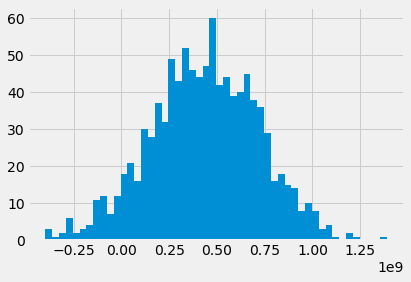

In [128]:
bootstrap_sample(target_valid_2, predicted_valid_2)

## Вывод

Среднее значение прибыли макисмально в регионе 1 - 515 млн. руб. (регион 0 - 426 млн. руб., регион 2 - 435 млн. руб.). При этом, риск разработки 200 скважин с убытком - 1% в регионе 1 (регион 0 - 6%, регион 1 - 6,4%).  
Таким образом, регион 1 имеет риск получения убытка ниже заданного уровня (2,5% или меньше), средняя прибыль в нем макисмальна.